In this notebook I build the intuition regarding the data by plotting some graphs and checking some hypothesis about the data distributions. Also in the end I check coverage of different tokenization methods for further data manipulations and LSTM networks usage

In [0]:
!mkdir kaggle

In [0]:
import os
os.chdir('../root')

In [0]:
!mkdir .kaggle

In [0]:
os.chdir('.kaggle')

In [0]:
import json
token ={"username":"","key":""}
with open('kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!chmod 600 kaggle.json

In [9]:
!kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
new-york-state/nys-environmental-remediation-sites          NYS Environmental Remediation Sites                   6MB  2019-08-09 08:27:31           2144  
eliasdabbas/search-engine-results-flights-tickets-keywords  Search Engine Results - Flights & Tickets Keywords   22MB  2019-08-01 11:51:13           1569  
google/google-landmarks-dataset                             Google-Landmarks Dataset                            107MB  2019-08-09 12:00:27          10845  
new-york-city/new-york-city-current-job-postings            New York City Current Job Postings                    3MB  2019-08-04 22:04:44           6277  
AnalyzeBoston/crimes-in-boston                              Crim

In [0]:
os.chdir('../../content/kaggle')

In [0]:
!ls

In [12]:
!kaggle datasets download -d authman/pickled-crawl300d2m-for-kernel-competitions

100% 1.69G/1.69G [00:24<00:00, 69.7MB/s]
100% 1.69G/1.69G [00:24<00:00, 75.1MB/s]


In [13]:
!kaggle datasets download -d authman/pickled-glove840b300d-for-10sec-loading

 99% 2.32G/2.33G [00:34<00:00, 54.8MB/s]
100% 2.33G/2.33G [00:34<00:00, 71.9MB/s]


In [14]:
!unzip pickled-crawl300d2m-for-kernel-competitions.zip

Archive:  pickled-crawl300d2m-for-kernel-competitions.zip
  inflating: crawl-300d-2M.pkl       


In [15]:
!unzip pickled-glove840b300d-for-10sec-loading.zip

Archive:  pickled-glove840b300d-for-10sec-loading.zip
  inflating: glove.840B.300d.pkl     


In [16]:
!ls

crawl-300d-2M.pkl    pickled-crawl300d2m-for-kernel-competitions.zip
glove.840B.300d.pkl  pickled-glove840b300d-for-10sec-loading.zip


In [17]:
!git clone https://github.com/Tariq60/LIAR-PLUS.git

Cloning into 'LIAR-PLUS'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 77 (delta 2), reused 0 (delta 0), pack-reused 68
Unpacking objects: 100% (77/77), done.


In [18]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2019-08-09 14:56:49--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.163.173
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.163.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  13.6MB/s    in 1m 56s  

2019-08-09 14:58:47 (13.5 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
!gunzip GoogleNews-vectors-negative300.bin.gz

In [0]:
os.chdir('..')

In [0]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from gensim.parsing.preprocessing import STOPWORDS
import pickle
from tqdm import tqdm
tqdm.pandas()

COLUMN_NAMES = ['id', 'label', 'statement', 'subject', 'speaker',
               'speakers_job', 'state_info', 'party_aff', 'bt_cnt',
               'f_cnt', 'ht_cnt', 'mt_cnt', 'pf_cnt', 'context',
               'justification']

GLOVE_EMBEDDING_PATH = 'kaggle/glove.840B.300d.pkl'
CRAWL_EMBEDDING_PATH = 'kaggle/crawl-300d-2M.pkl'
GOOGLE_WORD2VEC_PATH = 'kaggle/GoogleNews-vectors-negative300.bin'
DATA_PATH = 'kaggle/LIAR-PLUS/'

In [22]:
!ls -la

total 20
drwxr-xr-x 1 root root 4096 Aug  9 14:52 .
drwxr-xr-x 1 root root 4096 Aug  9 14:36 ..
drwxr-xr-x 1 root root 4096 Aug  7 16:05 .config
drwxr-xr-x 3 root root 4096 Aug  9 14:59 kaggle
drwxr-xr-x 1 root root 4096 Aug  2 16:06 sample_data


In [23]:
train = pd.read_csv(DATA_PATH + 'dataset/train2.tsv', sep = '\t', names = COLUMN_NAMES)
test = pd.read_csv(DATA_PATH + 'dataset/test2.tsv', sep = '\t', names = COLUMN_NAMES)
valid = pd.read_csv(DATA_PATH + 'dataset/val2.tsv', sep = '\t', names = COLUMN_NAMES)

train['justification'].fillna('Empty', inplace = True)
test['justification'].fillna('Empty', inplace = True)
valid['justification'].fillna('Empty', inplace = True)
print(train.shape, test.shape, valid.shape)

(10240, 15) (1267, 15) (1284, 15)


In [24]:
train['label'].value_counts()

half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: label, dtype: int64

In [0]:
# Binary label translation
label_dict = {
    'half-true': 0,
    'false': 0,
    'mostly-true': 1,
    'true': 1,
    'barely-true': 1,
    'pants-fire': 0
}

train['binary_label'] = train['label'].map(label_dict)
valid['binary_label'] = valid['label'].map(label_dict)
test['binary_label'] = test['label'].map(label_dict)

In [26]:
train.head()

,id,label,statement,subject,speaker,speakers_job,state_info,party_aff,bt_cnt,f_cnt,ht_cnt,mt_cnt,pf_cnt,context,justification,binary_label
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...,0
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe...",0
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...,1
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...,0
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start...",0


In [27]:
# Nan values counts
train.isna().sum()

id                  0
label               0
statement           0
subject             2
speaker             2
speakers_job     2897
state_info       2208
party_aff           2
bt_cnt              2
f_cnt               2
ht_cnt              2
mt_cnt              2
pf_cnt              2
context           102
justification       0
binary_label        0
dtype: int64

### Most common unique values

In [0]:
def get_top_counts(COL = 'subject'):
    plt.title('Top 10 value counts for col: {}'.format(COL))
    COLUMNS = ['name', 'counts']
    data = pd.DataFrame(np.array([train[COL].value_counts().index, train[COL].value_counts().values]).T, columns = COLUMNS)
    sns.barplot(x = COLUMNS[1], y = COLUMNS[0], data = data.iloc[:10, :]);

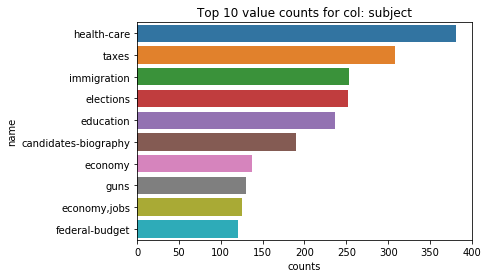

In [29]:
get_top_counts('subject')

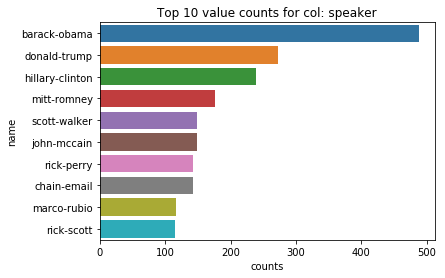

In [30]:
get_top_counts('speaker')

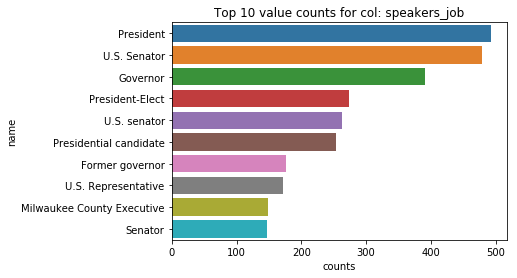

In [31]:
get_top_counts('speakers_job')

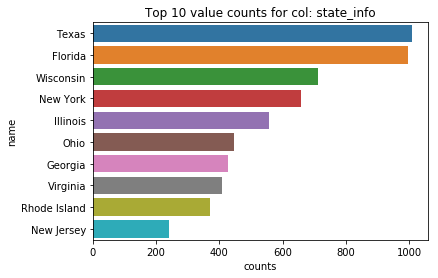

In [32]:
get_top_counts('state_info')

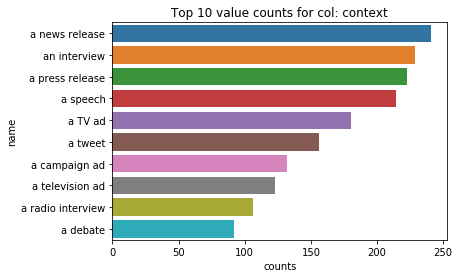

In [33]:
get_top_counts('context')

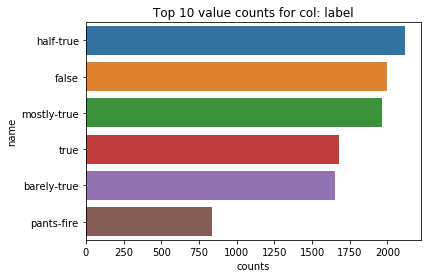

In [34]:
get_top_counts('label')

In [35]:
# Show a random statement, scores of people and the justification for it.
data = train.sample(n = 1)
print('Statement: {}'.format(data['statement'].iloc[0]))
print('Scores: {}'.format(data.iloc[:, 8:13].iloc[0]))
print('Justification: {}'.format(data['justification'].iloc[0]))

Statement: Obama has racked up more debt than any president in history over $5 trillion.
Scores: bt_cnt    5.0
f_cnt     3.0
ht_cnt    4.0
mt_cnt    1.0
pf_cnt    1.0
Name: 684, dtype: float64
Justification: Experts note, too, that the weak economy has contributed to the debt, given the reduction in federal revenues and greater spending on items like unemployment benefits. Renacci is accurate in asserting that the national debt has increased since Obama took office by more than $5 trillion, more than any previous administration. But his statement assigns direct control -- and blame -- to Obama. Lost in that is the impact of the faltering economy, decisions made before Obama took office and the fact that others, such as Congress, also have had a role in increasing the debt.


In [36]:
# Total number of unique values
for col in train.columns:
    if col != 'statement' and col != 'justification':
        print('Column: {}, unique values count: {}'.format(col, len(train[col].unique())))

Column: id, unique values count: 10240
Column: label, unique values count: 6
Column: subject, unique values count: 3828
Column: speaker, unique values count: 2911
Column: speakers_job, unique values count: 1185
Column: state_info, unique values count: 85
Column: party_aff, unique values count: 24
Column: bt_cnt, unique values count: 31
Column: f_cnt, unique values count: 31
Column: ht_cnt, unique values count: 30
Column: mt_cnt, unique values count: 28
Column: pf_cnt, unique values count: 21
Column: context, unique values count: 4346
Column: binary_label, unique values count: 2


### Word clouds

In [0]:
stopwords = set(STOPWORDS)
 
# TAKEN FROM: https://www.kaggle.com/gpreda/jigsaw-eda

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

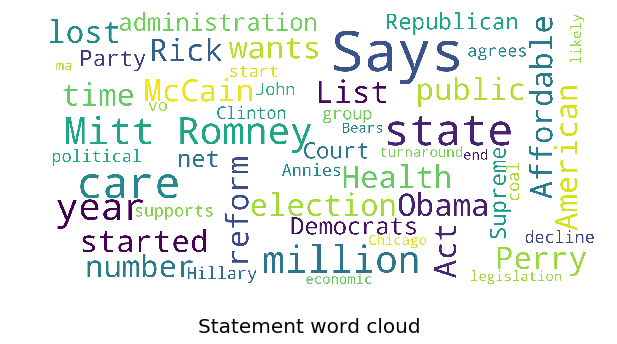

In [38]:
# Most common words for statement column
show_wordcloud(train['statement'], 'Statement word cloud')

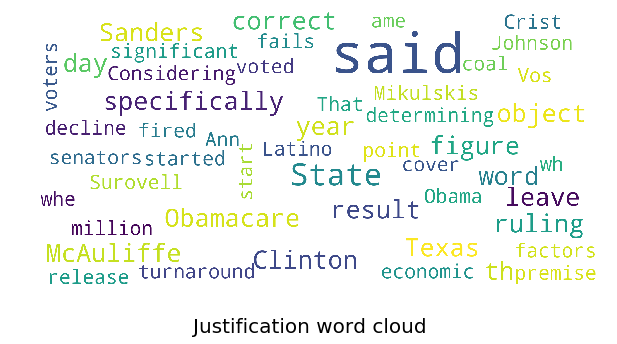

In [39]:
# Most common words for justification column
show_wordcloud(train['justification'], 'Justification word cloud')

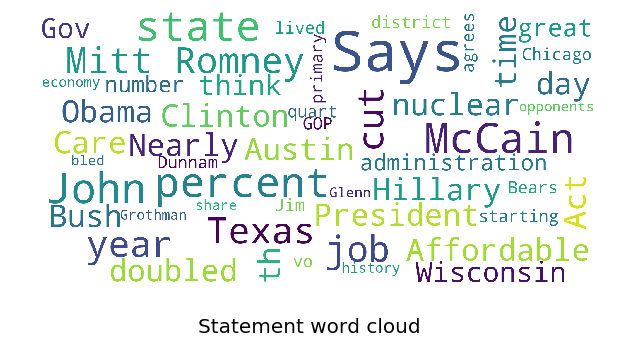

In [40]:
# Most common words for statement column, where label is 1
show_wordcloud(train[train['binary_label'] == 1]['statement'], 'Statement word cloud')

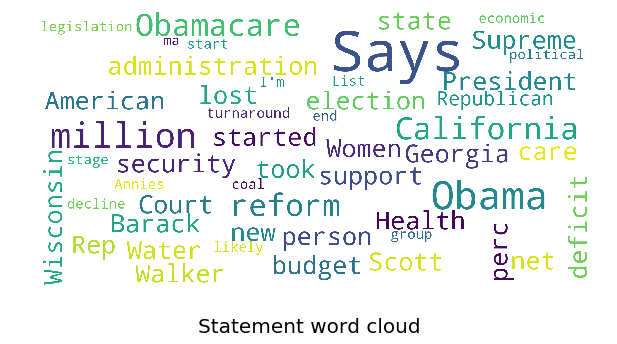

In [41]:
# Most common words for statement column, where label is 0
show_wordcloud(train[train['binary_label'] == 0]['statement'], 'Statement word cloud')

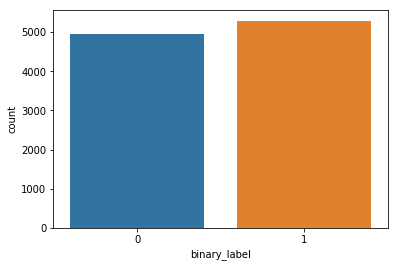

In [42]:
# counts of binary target
sns.countplot(train['binary_label'])

### Text tokenization and checking to fit Google New embeddings

In [0]:
import operator 

# TAKEN FROM https://www.kaggle.com/christofhenkel/how-to-preprocessing-for-glove-part1-eda

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [0]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')


def load_embeddings(path):
    with open(path,'rb') as f:
        emb_arr = pickle.load(f)
    return emb_arr

def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

### Glove embeddings check

In [45]:
import time 
tic = time.time()
glove_embeddings = load_embeddings(GLOVE_EMBEDDING_PATH)
print(f'loaded {len(glove_embeddings)} word vectors in {time.time()-tic}s')

loaded 2196008 word vectors in 17.184643507003784s


In [46]:
vocab_statement = build_vocab(list(train['statement'].apply(lambda x:x.split())))
oov_statement = check_coverage(vocab_statement,glove_embeddings)
oov_statement[:10]

100%|██████████| 21678/21678 [00:00<00:00, 820740.75it/s]

Found embeddings for 65.17% of vocab
Found embeddings for  92.29% of all text


[('years,', 90),
 ('year,', 82),
 ('$1', 74),
 ('Obamacare.', 56),
 ('combined.', 54),
 ('(the', 49),
 ('said,', 45),
 ('office,', 43),
 ('law,', 41),
 ('governor,', 39)]

In [47]:
vocab_justification = build_vocab(list(train['justification'].apply(lambda x:x.split())))
oov_justification = check_coverage(vocab_justification,glove_embeddings)
oov_justification[:10]

100%|██████████| 49317/49317 [00:00<00:00, 790126.93it/s]

Found embeddings for 53.05% of vocab
Found embeddings for  89.89% of all text


[('said,', 1059),
 ('"The', 779),
 ('However,', 469),
 ('Still,', 311),
 ('fact,', 299),
 ('"We', 285),
 ('"the', 285),
 ('that,', 255),
 ('years,', 252),
 ('"In', 241)]

### Crawl embeddings check

In [48]:
import time 
tic = time.time()
crawl_embeddings = load_embeddings(CRAWL_EMBEDDING_PATH)
print(f'loaded {len(crawl_embeddings)} word vectors in {time.time()-tic}s')

loaded 2000000 word vectors in 15.654460668563843s


In [49]:
vocab_statement = build_vocab(list(train['statement'].apply(lambda x:x.split())))
oov_statement = check_coverage(vocab_statement,crawl_embeddings)
oov_statement[:10]

100%|██████████| 21678/21678 [00:00<00:00, 811315.45it/s]

Found embeddings for 71.40% of vocab
Found embeddings for  94.15% of all text


[('$1', 74),
 ('(the', 49),
 ('office,', 43),
 ('law,', 41),
 ('governor,', 39),
 ('$2', 38),
 ("Obama's", 37),
 ('$500', 34),
 ('ago,', 33),
 ('Texas,', 32)]

In [50]:
vocab_justification = build_vocab(list(train['justification'].apply(lambda x:x.split())))
oov_justification = check_coverage(vocab_justification,crawl_embeddings)
oov_justification[:10]

100%|██████████| 49317/49317 [00:00<00:00, 791993.52it/s]

Found embeddings for 59.16% of vocab
Found embeddings for  91.98% of all text


[('Still,', 311),
 ('fact,', 299),
 ('"We', 285),
 ('"the', 285),
 ('"In', 241),
 ("Obama's", 229),
 ('sharethefacts', 216),
 ('"But', 213),
 ('"I', 182),
 ('percent,', 171)]